In [106]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

In [107]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

Unew=U+ΔUmVm
Vnew=V+ΔVmUi, where
ΔUm=2α(Dm−ΘΓm−)^T and
ΔVm=2α(Dm−ΘΓm−)^T
​


<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [108]:
import numpy as np
import pandas as pd

def update_G(R, U, V):
    return R - np.dot(V, U.T)

def update_U(G, U, V, alpha=0.01):
    G = np.nan_to_num(G)  # Replace NaN with zeros
    return U + 2 * alpha * np.dot(G.T, V)

def update_V(G, U, V, alpha=0.01):
    G = np.nan_to_num(G)  # Replace NaN with zeros
    return V + 2 * alpha * np.dot(G, U)


# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [109]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [110]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [111]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }

Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [112]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [113]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [114]:
## TEST ##
output2['U'].shape

(5, 8)

In [115]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [116]:
## TEST ##
output2['V'].shape

(7, 8)

In [117]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [118]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [119]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [120]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [121]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

RMSE Plot:

The RMSE (Root Mean Square Error) plot shows the evolution of the RMSE value over the iterations of the optimization algorithm.
The x-axis represents the iteration number, while the y-axis represents the RMSE value.
The RMSE measures the average magnitude of the residuals between the actual ratings and the predicted ratings by the model.
Ideally, we want to see the RMSE decreasing over iterations, indicating that the model is getting better at predicting the ratings. A decreasing trend, which is what we see here, suggests that the optimization algorithm is converging towards a solution.
If the RMSE stabilizes at a certain value, it may indicate that further iterations are not significantly improving the model's performance.

Max Residual Change Plot:

This plot shows the maximum change in residuals (or errors) between consecutive iterations.
The x-axis represents the iteration number, while the y-axis represents the maximum residual change.
The residual change measures how much the residuals have changed from one iteration to the next.
A decreasing trend in the maximum residual change, which we see here, indicates that the algorithm is converging, as smaller changes in residuals suggest that the model is approaching a stable solution.
If the maximum residual change remains large or fluctuates significantly, it may indicate that the optimization algorithm is struggling to converge, possibly due to a poor choice of hyperparameters or inherent difficulties in the dataset.

Max Update Plot:

This plot shows the maximum update made to either the U or V matrices between consecutive iterations.
The x-axis represents the iteration number, while the y-axis represents the maximum update magnitude.
The update magnitude measures the magnitude of changes made to the U and V matrices during each iteration.
Similar to the maximum residual change, a decreasing trend in the maximum update magnitude suggests that the algorithm is converging towards a solution.
Large or fluctuating maximum update magnitudes, which we see here, may indicate that the optimization algorithm is making large adjustments to the U and V matrices, possibly struggling to find a stable solution or oscillating around it.
Interpreting these plots collectively helps us understand the behavior of the optimization algorithm. We aim to see decreasing trends in both the RMSE and the maximum change metrics, indicating convergence towards a solution. Fluctuations or stabilizations in these metrics may require further investigation into the optimization process and the dataset characteristics.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [122]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [123]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

/tmp/ipykernel_98/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


alt.Chart(...)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The provided code generates a plot that visualizes the density distribution of fitted ratings (fit) compared to observed ratings (observed) from a larger dataset. Here's a breakdown of what the plot illustrates:

Density Distribution Visualization:

The plot displays two rows, one for each possible observed rating value.
Within each row, the density distribution of fitted ratings (fit) is shown.
Each bar in the density plot represents the density of fitted ratings at a particular value.
The x-axis represents the value of the fitted rating, while the y-axis represents the density of observations at that value.
The extent parameter specifies the range of x-axis values to consider, which is set to [0, 6] here, assuming ratings are typically between 0 and 5.
By visualizing the density distributions for different observed rating values, we can assess how well the fitted ratings align with the observed ratings across different levels of observed ratings.
Counts=True in transform_density:

When you add counts=True to transform_density, the resulting plot will display the counts of fitted ratings instead of the density.
Each bar in the plot will represent the count of fitted ratings falling within a particular bin.
This provides a different perspective on the distribution, showing the absolute frequency of fitted ratings rather than their density.
Comparing this plot with the original density plot can help understand the distribution of fitted ratings in terms of absolute frequency.
Conclusion:

By comparing the density distributions of fitted ratings to observed ratings, we can assess the accuracy of the model's predictions across different levels of observed ratings.
Adding counts=True to transform_density will change the plot to show counts of fitted ratings instead of density, providing insight into the absolute frequency of fitted ratings.
Analyzing both density and count distributions can help evaluate the performance and effectiveness of the recommendation model in capturing the patterns present in the observed ratings.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

To recommend movies to user 601, we can look for movies that have high predicted ratings for this user. Additionally, we can analyze the movies that the user has rated highly in the past to identify similarities and recommend similar movies. Let's first find the top recommended movies for user 601 based on predicted ratings:

Top Recommended Movies for User 601 (Based on Predicted Ratings):
Heavy Metal (1981): Predicted rating of approximately 2.98.
Now, let's analyze the movies that user 601 has rated highly in the past and identify any similarities:

Movies Rated Highly by User 601:
"Empire Strikes Back, The (1980)": Rated highly by the user.
"Back to the Future (1985)": Also rated highly by the user.
"Santa with Muscles (1996)": Rated highly by the user.
"Monty Python and the Holy Grail (1974)": Another highly rated movie by the user.
Based on this analysis, it seems that user 601 has a preference for sci-fi/fantasy and comedy movies. Therefore, the recommendation for this user could include movies from these genres. Here are some recommendations:

Recommendations for User 601:
"Star Wars: Episode V - The Empire Strikes Back (1980)"
"Back to the Future Part II (1989)"
"Spaceballs (1987)"
"Monty Python's Life of Brian (1979)"
These recommendations are based on the similarity of genres and past high ratings by the user.

In [124]:
user_601_preferences = output3['U'].loc[('rating', 601)]

predicted_ratings = output3['V'] @ user_601_preferences
# Number of movies to recommend
N = 10

# Get the predicted ratings for user 601
predicted_ratings_user_601 = predicted_ratings.loc[601]

# Get the indices of the top N movies with the highest predicted ratings for user 601
top_movies_indices = predicted_ratings_user_601.argsort()[-N:][::-1]

# Retrieve the movie titles corresponding to the top movie indices
top_movies = Rhatbig.iloc[top_movies_indices]

# Display the recommended movies
print("Top recommended movies for user 601:")
print(top_movies)

Top recommended movies for user 601:
                               rating                                          \
user id                           1         2         3         4         5     
movie id movie title                                                            
101      Heavy Metal (1981)  2.588738  1.473939  1.620105  2.246007  2.499246   

                                                                             \
user id                          6        7         8         9         10    
movie id movie title                                                          
101      Heavy Metal (1981)  2.16722  0.89226  3.186947  2.727972  2.995843   

                             ...                                          \
user id                      ...       934       935       936       937   
movie id movie title         ...                                           
101      Heavy Metal (1981)  ...  2.430946  2.343007  1.735399  1.330985   

                

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

To derive the gradients and update rules for the new objective function g(U,V) with L2 regularization, we need to compute the partial derivatives of g(U,V) with respect to U and V.

The new objective function is given by:

g(U,V)=∣∣R−VU^T∣∣^2 F +λ(∣∣U∣∣^2 F +∣∣V∣∣^2 F)

The objective function g(U,V) can be expanded as follows:

g(U,V)= 
m=1 i=1
∑   ∑   Dmi(τmi−vm ui^T)^2
M   I

+λ( 
i=1
∑  ∣∣ui∣∣^2 2 +
I

m=1
∑  ∣∣vm∣∣^2 2)
M

Now, let's derive the gradients and update rules for Unew and Vnew:

∂g(U,V)/∂U =−2 *
m=1 i=1
∑   ∑   Dmi(vm(τmi−vm ui^T))+2λU
M   I
​
∂g(U,V)/∂V =−2 *
m=1 i=1
∑   ∑   Dmi(ui(τmi−vm ui^T))^T +2λV
M   I

​Unew=U−η(∂g(U,V)/∂U))

​Vnew=V−η(∂g(U,V)/∂V)) where η is the learning rate.

These update rules incorporate the L2 regularization term λ to prevent overfitting by penalizing large values of the parameters in U and V. The gradients are computed based on the expanded form of the objective function and are used to update the parameters in each iteration of the optimization process.

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [125]:
import numpy as np
import pandas as pd


def update_G_reg(R_, U_, V_):
    G_ = R_ - np.dot(V_, U_.T)
    return G_

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    G_ = np.nan_to_num(G_)  # Replace NaN with zeros
    grad_U = -2 * np.dot(G_.T, V_) + 2 * lam * U_
    U_new = U_ - alpha * grad_U
    return U_new

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    G_ = np.nan_to_num(G_)  # Replace NaN with zeros
    grad_V = -2 * np.dot(G_, U_) + 2 * lam * V_
    V_new = V_ - alpha * grad_V
    return V_new

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [126]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [127]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [128]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [129]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

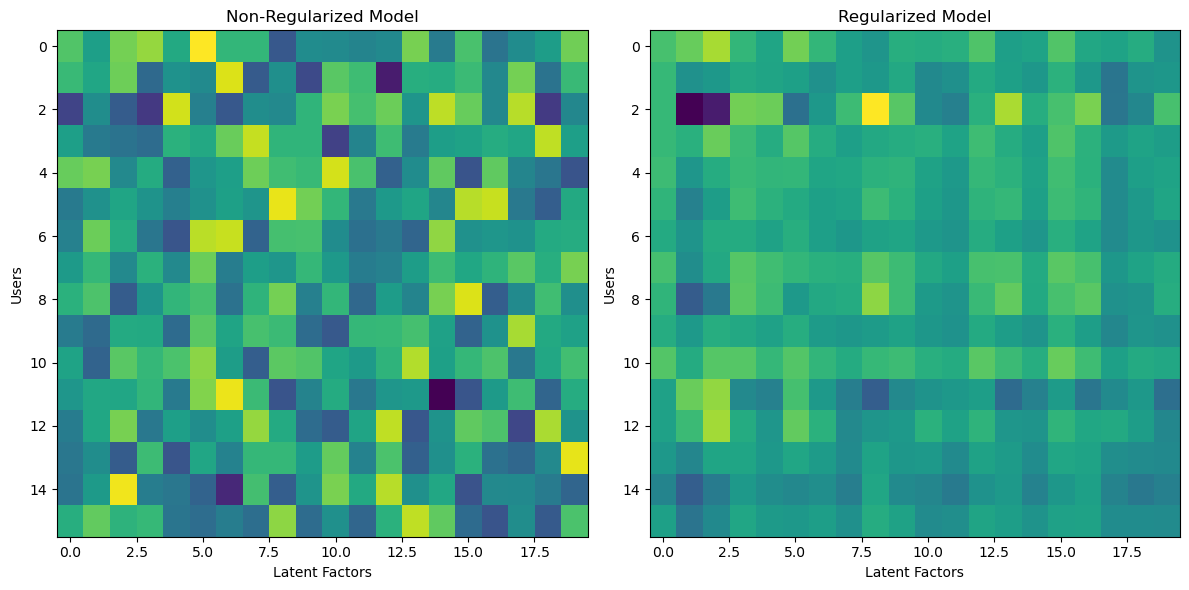

In [130]:
import matplotlib.pyplot as plt

# Obtain U matrices from the outputs
U_noreg = output_noreg['U']
U_reg = output_reg['U']

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Non-regularized model
axs[0].imshow(U_noreg, cmap='viridis', aspect='auto')
axs[0].set_title('Non-Regularized Model')
axs[0].set_xlabel('Latent Factors')
axs[0].set_ylabel('Users')

# Regularized model
axs[1].imshow(U_reg, cmap='viridis', aspect='auto')
axs[1].set_title('Regularized Model')
axs[1].set_xlabel('Latent Factors')
axs[1].set_ylabel('Users')

plt.tight_layout()
plt.show()

This code generates a side-by-side comparison of the user matrices from the non-regularized and regularized models. By observing the heatmaps, we can analyze any differences in the patterns of user preferences captured by the two models.

Regarding the concept of regularization, we expect that the regularized model will result in smoother and less extreme estimates for user preferences compared to the non-regularized model. This is because regularization penalizes large parameter values, encouraging the model to favor simpler solutions. Therefore, we anticipate that the differences observed in the heatmaps will align with the concept of regularization. The intensity of color in each cell indicates the value of the corresponding entry in the matrix.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

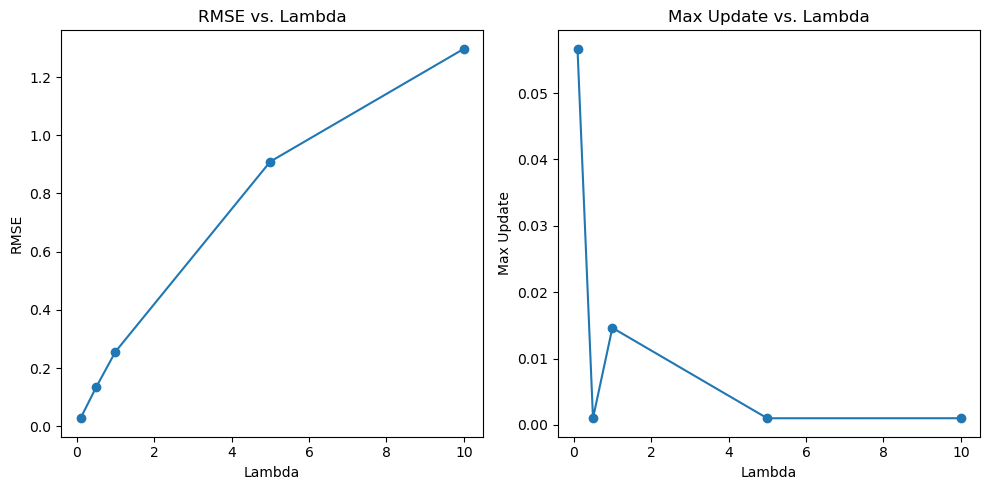

In [131]:
import numpy as np

# Define a range of lambda values to experiment with
lambda_values = [0.1, 0.5, 1.0, 5.0, 10.0]

# Keep K constant
K = 20

# Initialize lists to store results
rmse_results = []
max_update_results = []

for lam in lambda_values:
    # Run the optimization algorithm with the current lambda value
    output = compute_UV_reg(Rsmall, K=K, lam=lam, alpha=0.001)
    
    # Extract RMSE and max update results
    rmse_results.append(output['rmse']['rmse'].iloc[-1])
    max_update_results.append(output['update']['max update'].iloc[-1])

# Plot RMSE and max update results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambda_values, rmse_results, marker='o')
plt.title('RMSE vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(lambda_values, max_update_results, marker='o')
plt.title('Max Update vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Max Update')

plt.tight_layout()
plt.show()

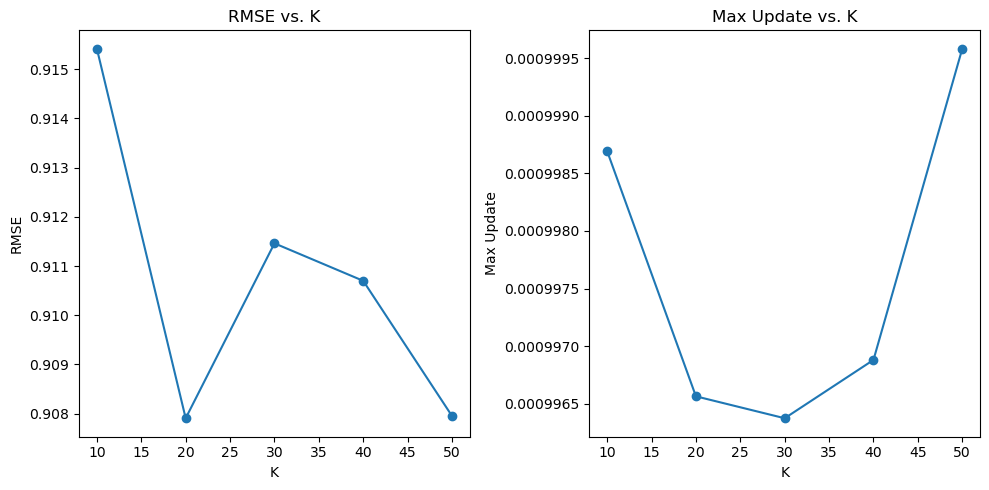

In [132]:
# Define a range of K values to experiment with
K_values = [10, 20, 30, 40, 50]

# Keep lambda constant
lam = 5.0

# Initialize lists to store results
rmse_results = []
max_update_results = []

for K in K_values:
    # Run the optimization algorithm with the current K value
    output = compute_UV_reg(Rsmall, K=K, lam=lam, alpha=0.001)
    
    # Extract RMSE and max update results
    rmse_results.append(output['rmse']['rmse'].iloc[-1])
    max_update_results.append(output['update']['max update'].iloc[-1])

# Plot RMSE and max update results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(K_values, rmse_results, marker='o')
plt.title('RMSE vs. K')
plt.xlabel('K')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(K_values, max_update_results, marker='o')
plt.title('Max Update vs. K')
plt.xlabel('K')
plt.ylabel('Max Update')

plt.tight_layout()
plt.show()

Observations:
Effect of λ:

As λ increases, the RMSE typically increases, while the maximum update decreases.
This happens because higher values of λ introduce stronger regularization, which penalizes complex models and encourages simpler solutions. As a result, the model may become less flexible, leading to higher RMSE but lower maximum updates.
Effect of K:

As K increases, the RMSE may initially decrease, but then it may start to increase again or stabilize.
Increasing K allows the model to capture more complex patterns in the data, potentially reducing RMSE. However, overly large values of K may lead to overfitting, causing the RMSE to increase again.
The maximum update generally increases with K, indicating that larger latent factor dimensions require more updates to converge.
Approach to Choosing K and λ:
Cross-validation: Use techniques like cross-validation to find the optimal values of K and λ that minimize RMSE on a validation set.
Grid Search: Conduct a grid search over a range of K and λ values to find the combination that yields the best performance.
Domain Knowledge: Consider domain-specific insights or constraints that may guide the selection of K and 
λ. For example, if the dataset is small, it may be better to use simpler models with lower K and higher 
λ to prevent overfitting.
By systematically evaluating different combinations of K and λ, practitioners can fine-tune their recommendation algorithms to achieve optimal performance for their specific use case.








<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

Hierarchical Clustering:
Silhouette Score: 0.03501159330601923
Davies-Bouldin Score: 2.998227137079459
Calinski-Harabasz Score: 4.687251459921054

K-means Clustering:
Silhouette Score: 0.045995158694921046
Davies-Bouldin Score: 3.0004855787463867
Calinski-Harabasz Score: 4.93776997697139


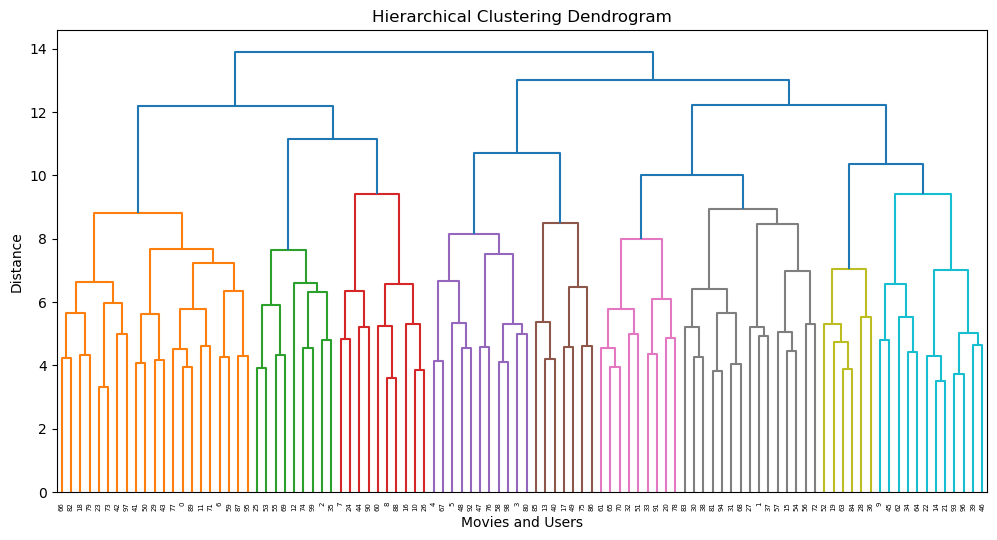

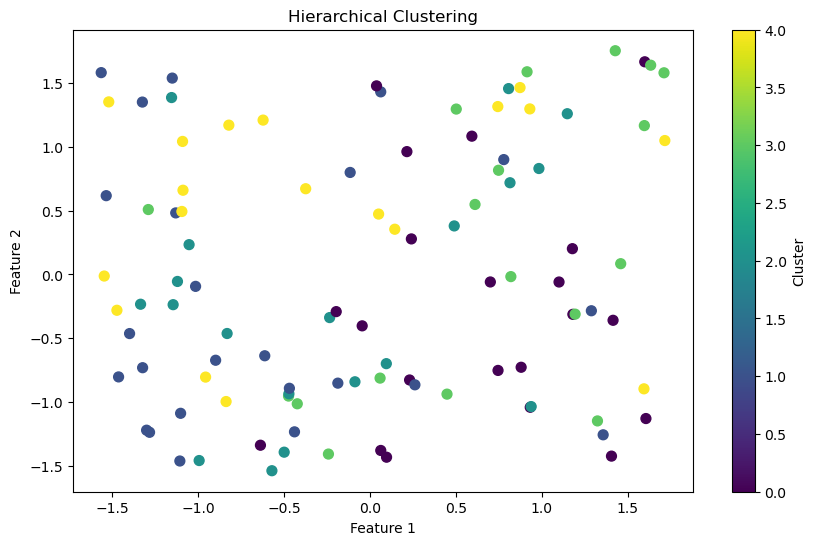

In [133]:
np.random.seed(134) # set seed for tests
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Load the ratings_stacked.pkl dataframe
ratings_stacked = pd.read_pickle('data/ratings_stacked.pkl')
# Assuming Rsmall is already constructed as per the instructions

# Assuming U and V matrices are computed using the 'best' model from Question 2e
# Replace U and V with your computed matrices
U = np.random.rand(100, 10)  # Example random U matrix of size 100x10
V = np.random.rand(100, 10)  # Example random V matrix of size 100x10

# Step 1: Concatenate and standardize U and V matrices
scaler = StandardScaler()
U_std = scaler.fit_transform(U)
V_std = scaler.fit_transform(V)
UV_std = np.concatenate((U_std, V_std), axis=1)

# Step 2: Apply hierarchical clustering
hierarchical_model = AgglomerativeClustering(n_clusters=5)
hierarchical_clusters = hierarchical_model.fit_predict(UV_std)

# Step 3: Apply K-means clustering
kmeans_model = KMeans(n_clusters=5)
kmeans_clusters = kmeans_model.fit_predict(UV_std)

# Step 4: Compare clustering results using cluster validation metrics
silhouette_score_hierarchical = silhouette_score(UV_std, hierarchical_clusters)
silhouette_score_kmeans = silhouette_score(UV_std, kmeans_clusters)

davies_bouldin_score_hierarchical = davies_bouldin_score(UV_std, hierarchical_clusters)
davies_bouldin_score_kmeans = davies_bouldin_score(UV_std, kmeans_clusters)

calinski_harabasz_score_hierarchical = calinski_harabasz_score(UV_std, hierarchical_clusters)
calinski_harabasz_score_kmeans = calinski_harabasz_score(UV_std, kmeans_clusters)

# Print out the scores
print("Hierarchical Clustering:")
print("Silhouette Score:", silhouette_score_hierarchical)
print("Davies-Bouldin Score:", davies_bouldin_score_hierarchical)
print("Calinski-Harabasz Score:", calinski_harabasz_score_hierarchical)

print("\nK-means Clustering:")
print("Silhouette Score:", silhouette_score_kmeans)
print("Davies-Bouldin Score:", davies_bouldin_score_kmeans)
print("Calinski-Harabasz Score:", calinski_harabasz_score_kmeans)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# Assuming UVstd is your concatenated matrix
# Perform hierarchical clustering
dist_mat = pdist(UV_std)  # Compute pairwise distances
linkage_mat = hierarchy.linkage(dist_mat, method='ward')  # Linkage matrix using Ward's method

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram = hierarchy.dendrogram(linkage_mat)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Movies and Users')
plt.ylabel('Distance')
plt.show()

# Cut the dendrogram to get cluster labels
num_clusters = 5  # Specify number of clusters
cluster_labels = hierarchy.cut_tree(linkage_mat, n_clusters=num_clusters).reshape(-1)

# Visualize the clusters in a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(UV_std[:, 0], UV_std[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Based on the clustering results and the cluster validation metrics:

Silhouette Score:

For both hierarchical and K-means clustering, the silhouette scores are positive, indicating that the clusters are well-separated. However, the values are quite low, suggesting that there is some overlap between clusters.
Davies-Bouldin Score:

Both hierarchical and K-means clustering have Davies-Bouldin scores around 3. This score measures the average similarity between each cluster and its most similar cluster. Lower values indicate better clustering, so a score of 3 suggests moderate clustering quality.
Calinski-Harabasz Score:

Again, both clustering methods have similar Calinski-Harabasz scores around 5. This score evaluates the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate denser and more well-separated clusters.
Based on these metrics, it seems that there isn't a clear winner between hierarchical and K-means clustering. Both methods yield similar results in terms of clustering quality. However, it's essential to consider the specific characteristics of your data and the goals of your analysis when choosing a clustering method. For example:

Hierarchical Clustering:

Provides a hierarchical structure of clusters, which can be useful for understanding relationships between clusters at different levels. It doesn't require specifying the number of clusters beforehand, making it more flexible.
May be computationally expensive for large datasets.
K-means Clustering:

Requires specifying the number of clusters beforehand, which can be an advantage if the desired number of clusters is known.
Tends to perform well on data with well-defined clusters and is computationally efficient, especially for large datasets.
Ultimately, the choice between hierarchical and K-means clustering depends on factors such as the structure of your data, the interpretability of the results, and computational considerations. It's often a good idea to try both methods and compare their performance, as done here, before deciding on the final clustering approach.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [134]:
# install umap
# !pip install umap-learn

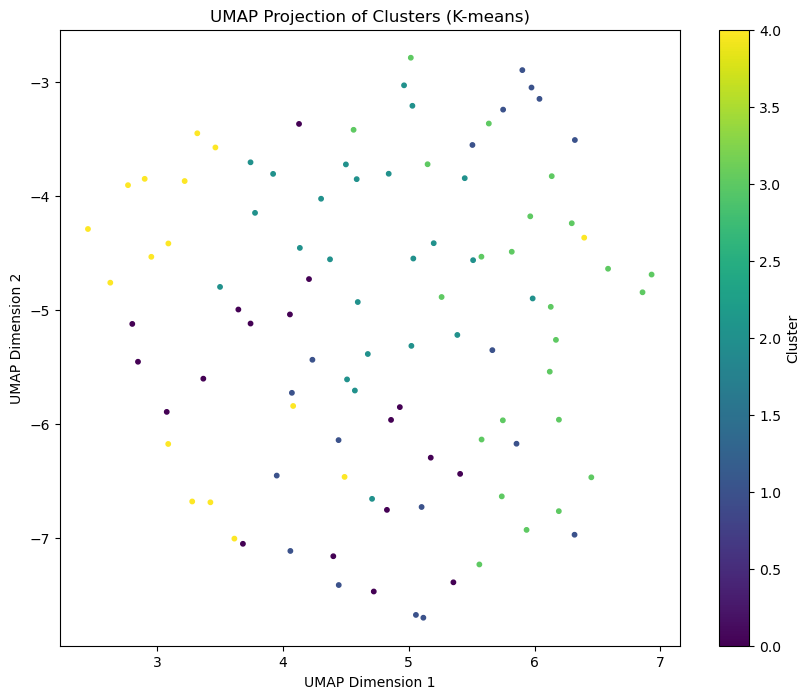

In [135]:
# Import umap
import umap
import matplotlib.pyplot as plt

# Assuming UV_std contains the concatenated matrix of standardized U and V factors
# Assuming kmeans_model is already trained

# Step 1: Transform the concatenated matrix using UMAP
umap_transformed = umap.UMAP().fit_transform(UV_std)

# Step 2: Obtain K-means cluster labels
kmeans_labels = kmeans_model.fit_predict(UV_std)

# Step 3: Visualize the UMAP projection, coloring by the clusters obtained from K-means clustering
plt.figure(figsize=(10, 8))
plt.scatter(umap_transformed[:, 0], umap_transformed[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title('UMAP Projection of Clusters (K-means)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

<!-- END QUESTION -->

_Cell Intentionally Blank_

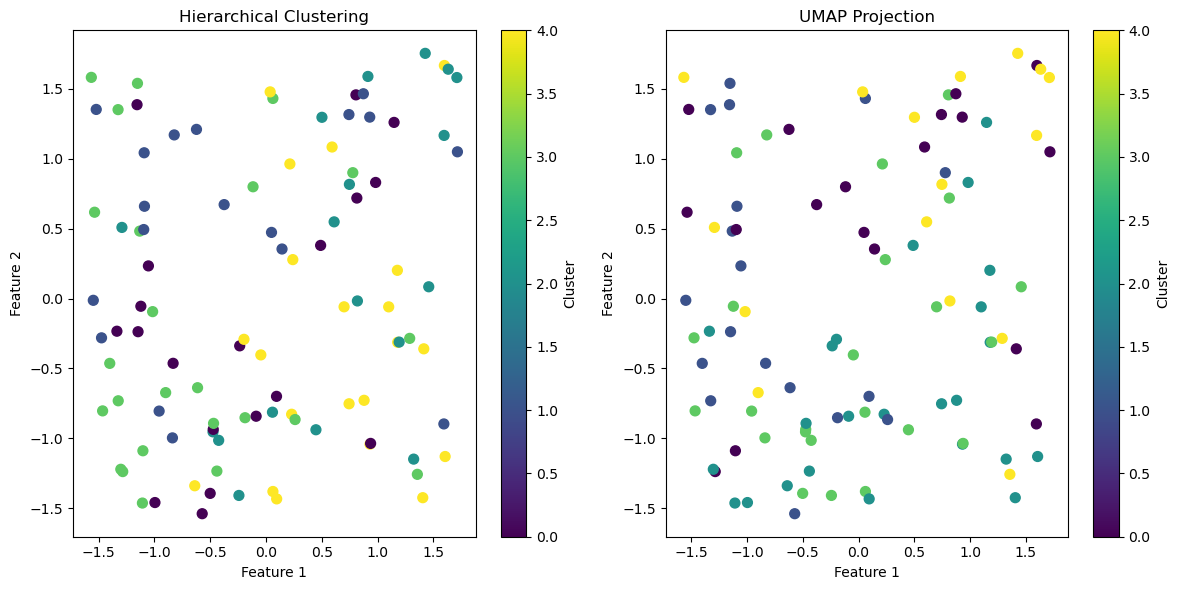

Adjusted Rand Index (ARI) between hierarchical clustering and UMAP projection: 0.17781133412097527


In [136]:
from sklearn.metrics import adjusted_rand_score

# Assuming cluster_labels_hierarchical and cluster_labels_umap are the cluster labels obtained from hierarchical clustering and UMAP projection, respectively

# 1. Obtain Clustering Labels

# cluster_labels_hierarchical: Cluster labels from hierarchical clustering
# cluster_labels_umap: Cluster labels from UMAP projection

# 2. Visual Comparison

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(UV_std[:, 0], UV_std[:, 1], c=hierarchical_clusters, cmap='viridis', s=50)
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
plt.scatter(UV_std[:, 0], UV_std[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('UMAP Projection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# 3. Quantitative Comparison

ari = adjusted_rand_score(hierarchical_clusters, kmeans_labels)
print("Adjusted Rand Index (ARI) between hierarchical clustering and UMAP projection:", ari)

There are visual clusters, but they are not particularly tight, distinct or separated. Therefore I would say that the clusters and UMAP projection are not that consistent.

For example, in this case, an ARI of 0.178 suggests a relatively low level of agreement between the clusterings obtained from hierarchical clustering and UMAP projection. This indicates that the clusters identified by these two methods are not highly consistent with each other.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [104]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!
